### Imports and Paths

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numba as nb
import time
%load_ext line_profiler

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

/home/gleung/miniconda3/envs/satlcc/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
from palettable.cartocolors.qualitative import Prism_8
prism = Prism_8.mpl_colors
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = '#303039'
#importing plotting parameters
style = '/home/gleung/scripts/styles/bee-paperlight.mplstyle'
#style = '/home/gleung/scripts/styles/bee-presentationtransparent.mplstyle'
plt.style.use(style)

import matplotlib.font_manager as font_manager
from matplotlib import rcParams

# Add every font at the specified location
font_dir = ['/home/gleung/scripts/futura']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Futura'

bg = 'white'
lcol = 'black'

In [3]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def add_latlon(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

In [75]:
dataPath = '/moonbow/gleung/satlcc/GSW_2020_v3/'
anaPath = '/moonbow/gleung/satlcc/GSW_processing/'

if not os.path.isdir(anaPath):
    os.mkdir(anaPath)

# Testing Functions

## Read GSW Data

In [17]:
print(sorted(os.listdir(f"{dataPath}occurrence/")))

['occurrence_100E_0Nv1_3_2020.tif', 'occurrence_100E_10Nv1_3_2020.tif', 'occurrence_100E_20Nv1_3_2020.tif', 'occurrence_100E_30Nv1_3_2020.tif', 'occurrence_110E_0Nv1_3_2020.tif', 'occurrence_110E_10Nv1_3_2020.tif', 'occurrence_110E_20Nv1_3_2020.tif', 'occurrence_110E_30Nv1_3_2020.tif', 'occurrence_120E_0Nv1_3_2020.tif', 'occurrence_120E_10Nv1_3_2020.tif', 'occurrence_120E_20Nv1_3_2020.tif', 'occurrence_120E_30Nv1_3_2020.tif', 'occurrence_130E_0Nv1_3_2020.tif', 'occurrence_130E_10Nv1_3_2020.tif', 'occurrence_130E_20Nv1_3_2020.tif', 'occurrence_130E_30Nv1_3_2020.tif', 'occurrence_90E_0Nv1_3_2020.tif', 'occurrence_90E_10Nv1_3_2020.tif', 'occurrence_90E_20Nv1_3_2020.tif', 'occurrence_90E_30Nv1_3_2020.tif']


In [66]:
lat = 0
lon = 100

var = 'occurrence'
path = f"{dataPath}{var}/{var}_{str(lon).zfill(3)}E_{str(lat)}Nv1_3_2020.tif"
watercover = np.array(Image.open(path))[::-1,::]
watercover = np.where(watercover!=255, watercover/100, np.nan)

In [ ]:
ave_res = 32 #32 arcseconds is approximately 1km
n = 125 #number of chunks to subset (~number of km x number of km box)

In [56]:
@nb.njit
def coarsen_res(watercover,ave_res=32):
    n = int(watercover.shape[0]/ave_res)
    watercover_coarse = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            watercover_coarse[i,j] = watercover[ave_res*i:ave_res*(i+1),ave_res*j:ave_res*(j+1)].sum()/(ave_res*ave_res)
                
    return(watercover_coarse)

In [67]:
%%time

watercover_coarse = coarsen_res(watercover,ave_res=32)

CPU times: user 11.9 s, sys: 706 ms, total: 12.6 s
Wall time: 12.6 s


In [68]:
#File name refers to top left corner of tile
lats = np.linspace(lat-10, lat, watercover_coarse.shape[0]+1)[1:]
lons = np.linspace(lon, lon+10, watercover_coarse.shape[1]+1)[:-1]

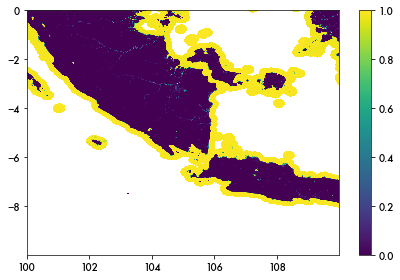

In [70]:
plt.pcolormesh(lons,lats,watercover_coarse)
plt.colorbar()

# Process All

In [76]:
lat = 10
lon = 110

starttime=time.time()
for lat in [0,10,20,30]:
    for lon in [90,100,110,120,130]:
        print(lat,lon)
        
        var = 'occurrence'
        path = f"{dataPath}{var}/{var}_{str(lon)}E_{str(lat)}Nv1_3_2020.tif"
        watercover = np.array(Image.open(path))[::-1,::]
        watercover = np.where(watercover!=255, watercover/100, np.nan)

        ave_res = 32 #32 arcseconds is approximately 1km
        n = 25 #number of chunks to subset (~number of km x number of km box)

        water = []
        for i in range(0,int(watercover.shape[0]/(ave_res*n))):
            watercover_rows = []
            for j in range(0,int(watercover.shape[1]/(ave_res*n))):
                watercover_ = watercover[i*ave_res*n:(i+1)*ave_res*n,j*ave_res*n:(j+1)*ave_res*n]
                
                watercover_coarse = coarsen_res(watercover_,ave_res)

                watercover_rows.append(watercover_coarse)

            water.append(np.concatenate(watercover_rows,axis=1))
            
        print('saving')
        water = np.concatenate(water,axis=0)
        np.save(f"{anaPath}watercover1km_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E", water)

        print(time.time()-starttime)

0 90
saving
32.60650420188904
0 100
saving
65.21404695510864
0 110
saving
97.22667288780212
0 120
saving
131.3312599658966
0 130
saving
167.48498249053955
10 90
saving
195.31187772750854
10 100
saving
227.59724140167236
10 110
saving
255.8324682712555
10 120
saving
286.84391736984253
10 130
saving
319.3632228374481
20 90
saving
349.5479509830475
20 100
saving
375.04936838150024
20 110
saving
393.8738708496094
20 120
saving
412.7563986778259
20 130
saving
430.55646085739136
30 90
saving
449.8030090332031
30 100
saving
470.53436064720154
30 110
saving
506.78902316093445
30 120
saving
537.1240408420563
30 130
saving
563.2676882743835
